In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import os

data_dir = "/mnt/sdb1/home/kygrachev/diploma/ratings/"

marks_data = []
dialog_data = []
for file in os.listdir(data_dir):
    with open(os.path.join(data_dir, file), "r", encoding="utf-8") as f:
        fileinfo = file.split("-")
        model = fileinfo[0]
        dialog_id = f"{fileinfo[1]}-{fileinfo[2].split('.')[0]}"

        j = json.load(f)

        total_words = 0
        total_generated_words = 0
        total_user_messages = 0
        marks = []
        for i, message in enumerate(j):
            if message["role"] == "user":
                total_user_messages += 1
                total_words += len(message["text"].split())
            else:
                if message["rating"]:
                    message["rating"]["message_id"] = i
                    marks.append(message["rating"])
                total_generated_words += len(message["text"].split())

        global_rate = j[0].get("global")
        if global_rate is None:
            global_rate = marks[-1]["The overall feeling of the dialogue"]

        df = pd.DataFrame(marks)
        df["model"] = model
        df["dialog_id"] = dialog_id

        marks_data.append(df)
        dialog_data.append({
            "model": model,
            "dialog_id": dialog_id,
            "global_rate": global_rate, 
            "total_user_messages": total_user_messages, 
            "total_words": total_words, 
            "total_generated_words": total_generated_words,
        })

marks_df = pd.concat(marks_data).rename(columns={
    "Correctness/adequacy/relevance/completeness": "Correctness", 
    "How empathetic is the response": "Empathetic", 
    "Usefulness of the tips": "Usefullness",
    "The overall feeling of the dialogue": "General"
})
marks_df["generated_message_id"] = marks_df["message_id"] // 2 + 1
marks_df = marks_df[["model", "Correctness", "Empathetic", "Usefullness", "General", "dialog_id", "generated_message_id"]]
dialog_df = pd.DataFrame(dialog_data)

# Средние значения

In [2]:
mean_dialog_lens = {}
for (model, ), df in marks_df.groupby(by=["model"]):
    lens = []
    for dialog_id, df_ in df.groupby("dialog_id"):
        lens.append(len(df_))
    mean_dialog_lens[model] = sum(lens) / len(lens)
mean_dialog_lens

{'BASE': 8.0, 'CBT': 7.4, 'CLF': 5.2, 'EMO': 6.4}

In [11]:
import pandas as pd
import numpy as np

stats = []

for model, df in marks_df.groupby("model"):
    dialog_lengths = df.groupby("dialog_id").size()
    mean_len = dialog_lengths.mean()
    std_len = dialog_lengths.std()
    stats.append({"model": model, "mean_length": mean_len, "std_dev": std_len})

# Создаем DataFrame со статистикой
length_stats_df = pd.DataFrame(stats)
print(length_stats_df)


  model  mean_length   std_dev
0  BASE          8.0  3.800585
1   CBT          7.4  6.149977
2   CLF          5.2  0.788811
3   EMO          6.4  2.951459


In [3]:
dialog_df["mean_user_words"] = dialog_df["total_words"] / dialog_df["total_user_messages"]
dialog_df["mean_generated_words"] = dialog_df["total_generated_words"] / dialog_df["total_user_messages"]
dialog_df.groupby(by=["model"])[["mean_user_words", "mean_generated_words"]].mean()

,mean_user_words,mean_generated_words
model,,
BASE,45.090433,88.934728
CBT,57.558421,178.086316
CLF,63.163333,123.210000
EMO,53.631667,175.221667


In [4]:
dialog_df.head().round(3)

,model,dialog_id,global_rate,total_user_messages,total_words,total_generated_words,mean_user_words,mean_generated_words
0,CLF,1746748840-g0198874,7,6,506,1039,84.333,173.167
1,CBT,1746724771-g2161677,10,5,289,901,57.800,180.200
2,EMO,1746725134-682831,10,3,202,496,67.333,165.333
3,CBT,1746721029-g3383427,5,19,909,3451,47.842,181.632
4,CLF,1746746705-591092,8,5,268,459,53.600,91.800


In [34]:
marks_df.head()

,model,Correctness,Empathetic,Usefullness,General,dialog_id,generated_message_id
0,CLF,8,7,8,8,1746748840-g0198874,1
1,CLF,8,6,7,7,1746748840-g0198874,2
2,CLF,7,7,7,7,1746748840-g0198874,3
3,CLF,8,8,9,8,1746748840-g0198874,4
4,CLF,7,9,7,7,1746748840-g0198874,5


# Изучение данных в динамике

In [32]:
import numpy as np

models = marks_df["model"].unique()
color_mapping = {
    m: c for m, c in zip(models, plt.cm.coolwarm(np.linspace(0, 1, len(models))))
}

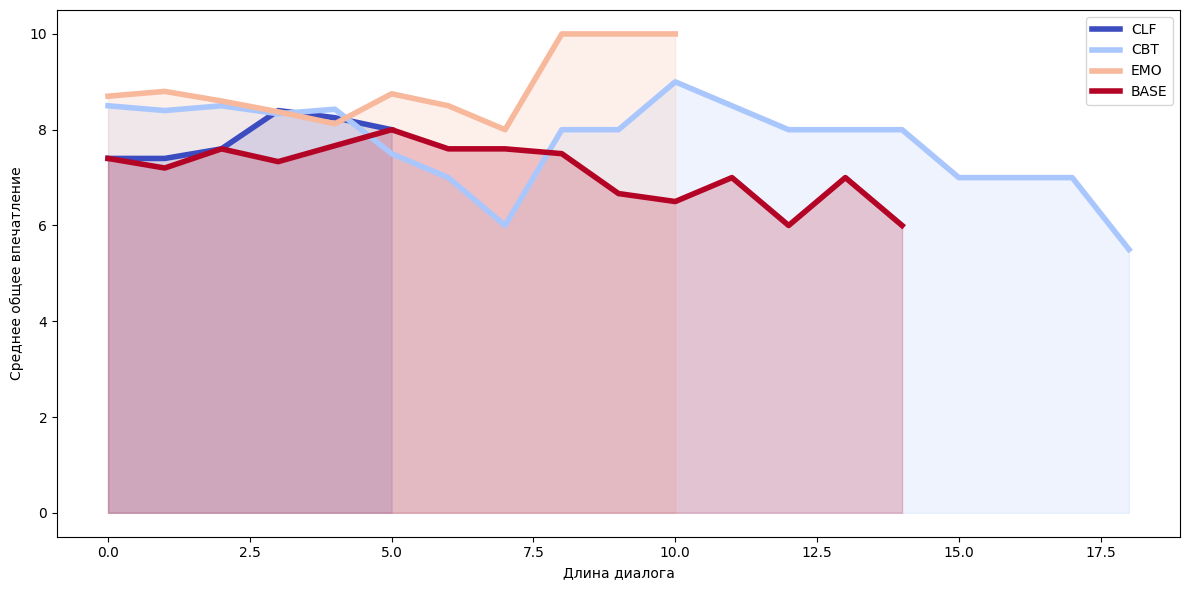

In [37]:
import matplotlib.pyplot as plt
import numpy as np

# Группируем и сбрасываем индекс
df = marks_df.groupby(["model", "generated_message_id"])["General"].mean().reset_index()

# Сортируем, чтобы линии не прыгали
df = df.sort_values(by=["model", "generated_message_id"])

plt.figure(figsize=(12, 6))

for model in models:
    model_df = df[df["model"] == model]
    
    # Если нужны числовые X, можно заменить ID на индекс
    x = np.arange(len(model_df))
    y = model_df["General"].values
    
    plt.plot(x, y, label=model, color=color_mapping[model], linewidth=4)
    plt.fill_between(x, y, alpha=0.2, color=color_mapping[model])

plt.xlabel("Длина диалога")
plt.ylabel("Среднее общее впечатление")
plt.legend()
plt.tight_layout()
plt.show()


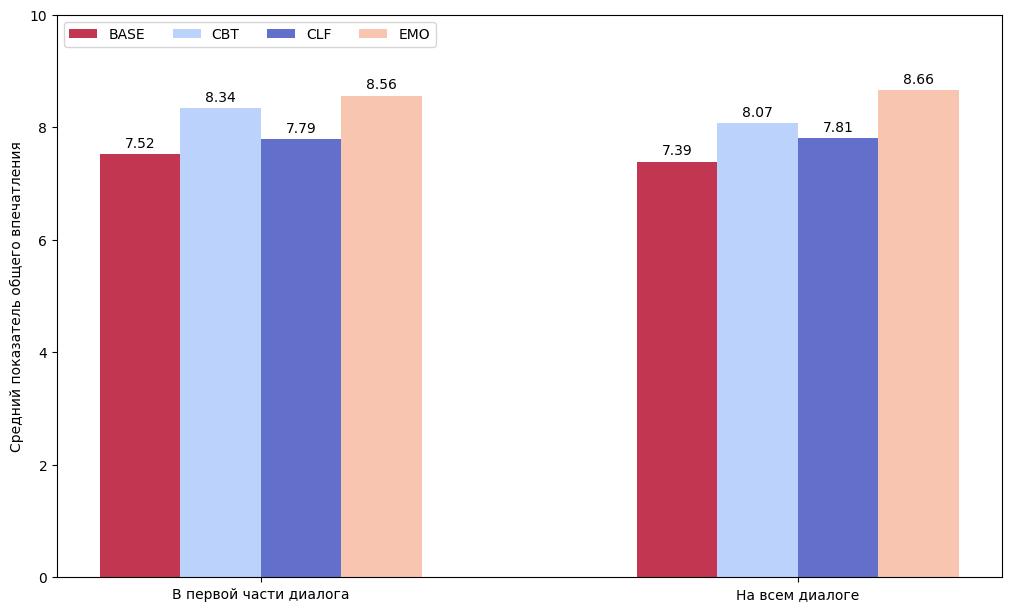

In [48]:
# data from https://allisonhorst.github.io/palmerpenguins/

import matplotlib.pyplot as plt
import numpy as np

species = ["В первой части диалога", "На всем диалоге"]
bar_data = {}
for (model, ), df in marks_df.groupby(["model"]):
    bar_data[model] = [
        df[df["generated_message_id"] <= mean_dialog_lens[model]]["General"].mean(),
        df["General"].mean(), 
    ]


x = np.arange(len(species))  # the label locations
width = 0.15  # the width of the bars
multiplier = 0

offsets = np.array([width * offset for offset in range(multiplier, len(bar_data))])
         
fig, ax = plt.subplots(layout='constrained')
fig.set_figheight(6)
fig.set_figwidth(10)
xes = []
for attribute, measurement in bar_data.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, np.round(measurement, 2), width, label=attribute, color=color_mapping[attribute], alpha=0.8)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Средний показатель общего впечатления')
ax.set_xticks(x + offsets.mean(), species)
ax.legend(loc='upper left', ncols=len(bar_data))
ax.set_ylim(0, 10)

plt.show()

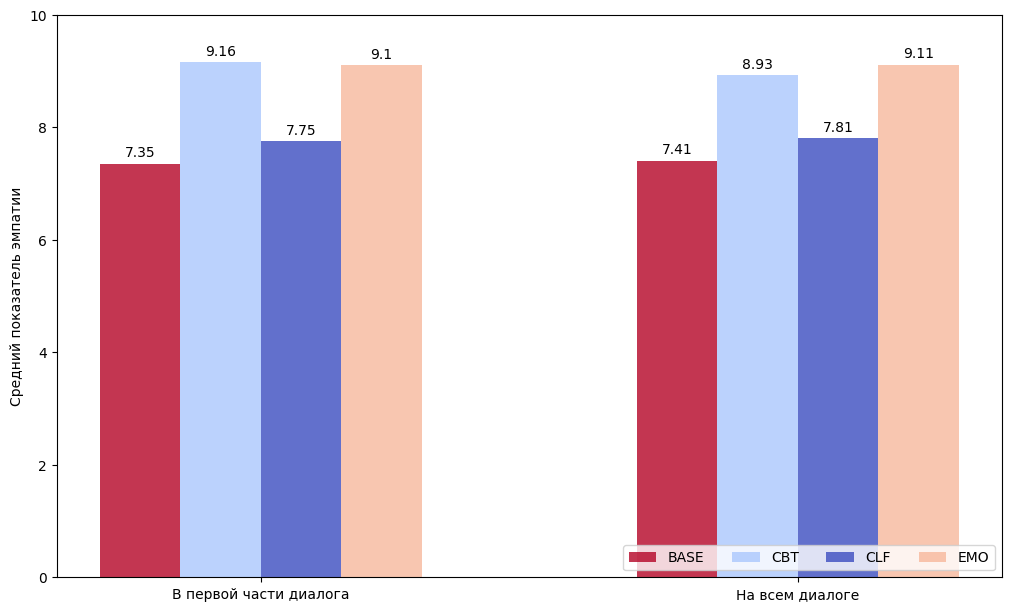

In [44]:
# data from https://allisonhorst.github.io/palmerpenguins/

import matplotlib.pyplot as plt
import numpy as np

species = ["В первой части диалога", "На всем диалоге"]
bar_data = {}
for (model, ), df in marks_df.groupby(["model"]):
    bar_data[model] = [
        df[df["generated_message_id"] <= mean_dialog_lens[model]]["Empathetic"].mean(),
        df["Empathetic"].mean(), 
    ]


x = np.arange(len(species))  # the label locations
width = 0.15  # the width of the bars
multiplier = 0

offsets = np.array([width * offset for offset in range(multiplier, len(bar_data))])
         
fig, ax = plt.subplots(layout='constrained')
fig.set_figheight(6)
fig.set_figwidth(10)
xes = []
for attribute, measurement in bar_data.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, np.round(measurement, 2), width, label=attribute, color=color_mapping[attribute], alpha=0.8)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Средний показатель эмпатии')
ax.set_xticks(x + offsets.mean(), species)
ax.legend(loc='lower right', ncols=len(bar_data))
ax.set_ylim(0, 10)

plt.show()

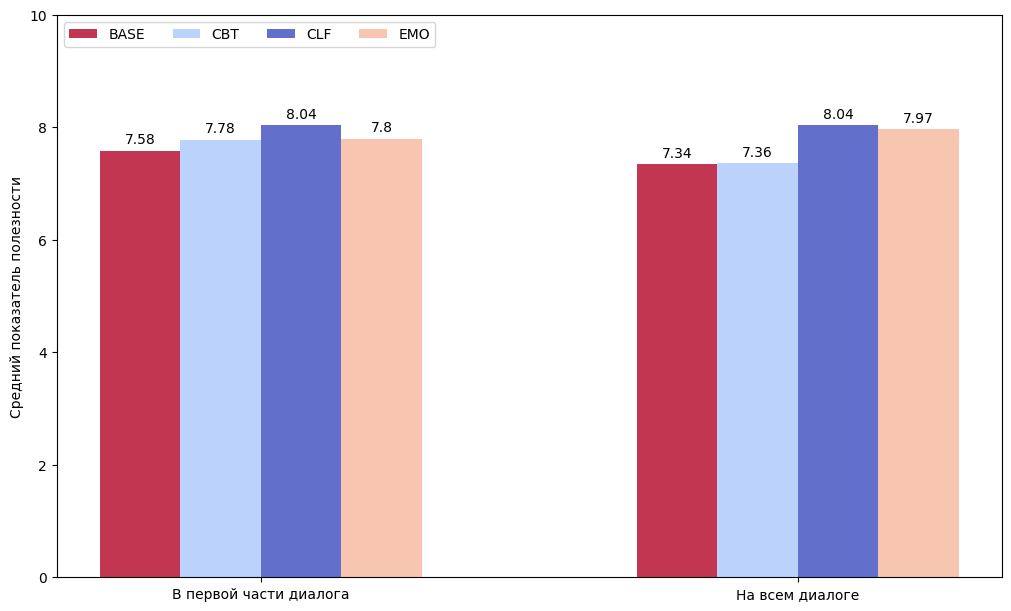

In [46]:
# data from https://allisonhorst.github.io/palmerpenguins/

import matplotlib.pyplot as plt
import numpy as np

species = ["В первой части диалога", "На всем диалоге"]
bar_data = {}
for (model, ), df in marks_df.groupby(["model"]):
    bar_data[model] = [
        df[df["generated_message_id"] <= mean_dialog_lens[model]]["Usefullness"].mean(),
        df["Usefullness"].mean(), 
    ]

x = np.arange(len(species))  # the label locations
width = 0.15  # the width of the bars
multiplier = 0

offsets = np.array([width * offset for offset in range(multiplier, len(bar_data))])
         
fig, ax = plt.subplots(layout='constrained')
fig.set_figheight(6)
fig.set_figwidth(10)
xes = []
for attribute, measurement in bar_data.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, np.round(measurement, 2), width, label=attribute, color=color_mapping[attribute], alpha=0.8)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Средний показатель полезности')
ax.set_xticks(x + offsets.mean(), species)
ax.legend(loc='upper left', ncols=len(bar_data))
ax.set_ylim(0, 10)

plt.show()

# Изучение корреляции в собранных данных

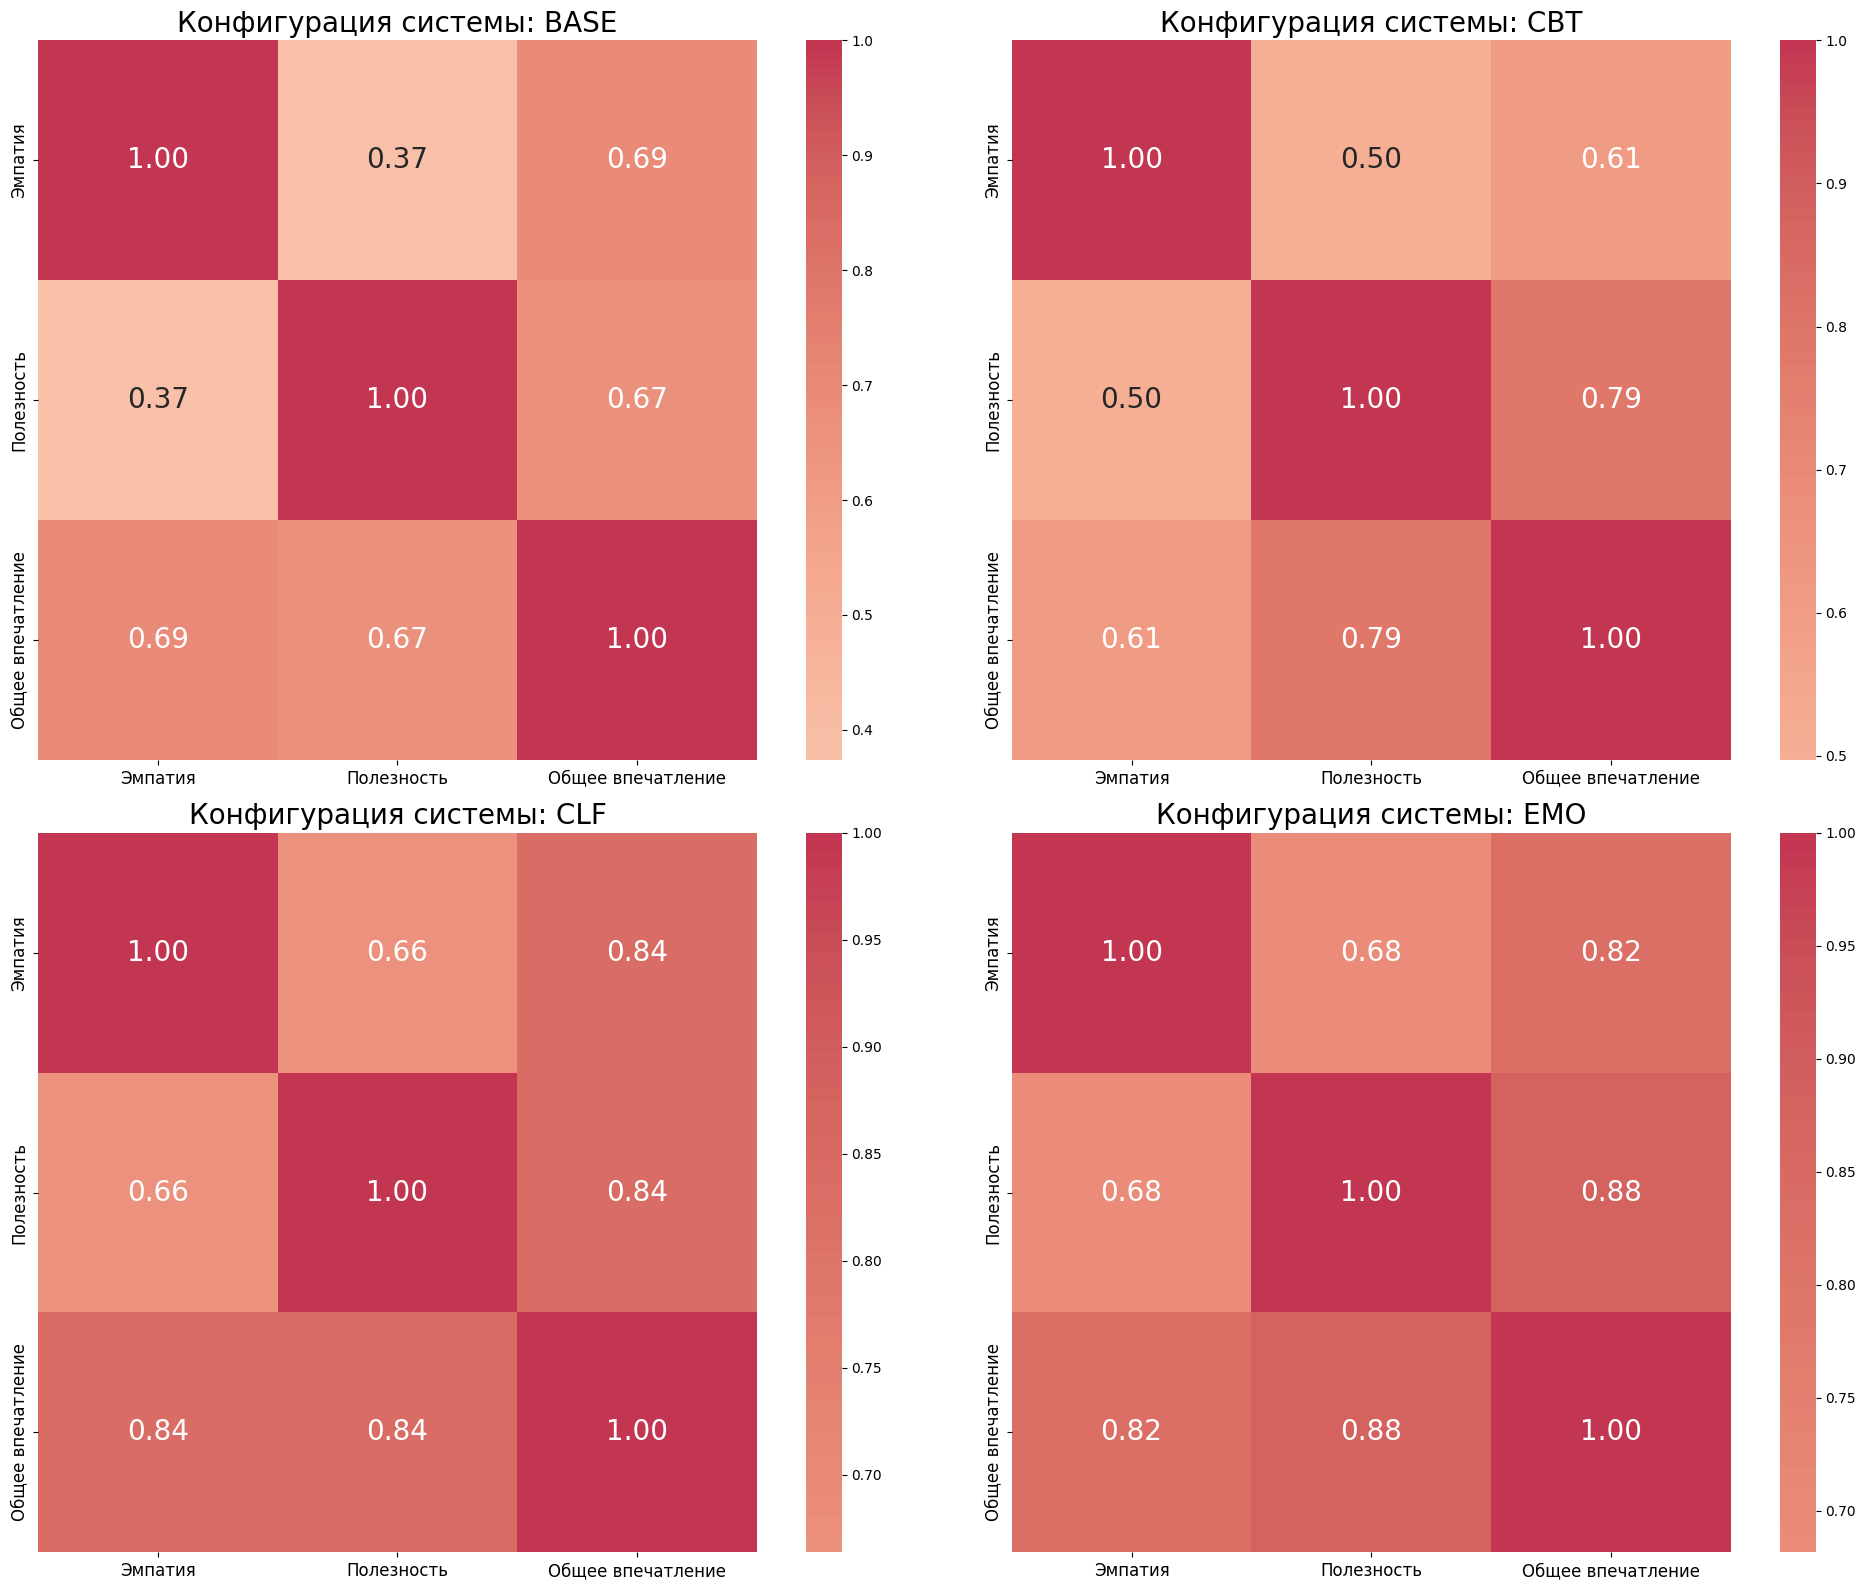

In [55]:

import matplotlib.pyplot as plt
import seaborn as sns

def gen():
    marks_df_tmp = marks_df.rename(columns={"Empathetic": "Эмпатия", "Usefullness": "Полезность", "General": "Общее впечатление"})
    for model, model_df in marks_df_tmp.groupby("model"):
        yield model, model_df[['Эмпатия', 'Полезность', 'Общее впечатление']].corr()

dfs = gen()

fig, axs = plt.subplots(2, 2, figsize=(20, 16))  # увеличенная фигура
axs = axs.flatten()

for ax in axs:
    try:
        name, corr_matrix = next(dfs)
        sns.heatmap(
            corr_matrix,
            annot=True,
            fmt=".2f",
            cmap="coolwarm",
            center=0,
            square=True,
            ax=ax,
            annot_kws={"fontsize": 20},
            alpha=0.8,  # размер текста в ячейках
        )
        ax.set_title(f"Конфигурация системы: {name}", fontsize=20)  # заголовок
        ax.tick_params(axis='both', labelsize=12)  # подписи осей
    except StopIteration:
        ax.axis('off')  # скрыть пустую ось
    
plt.tight_layout()
plt.show()


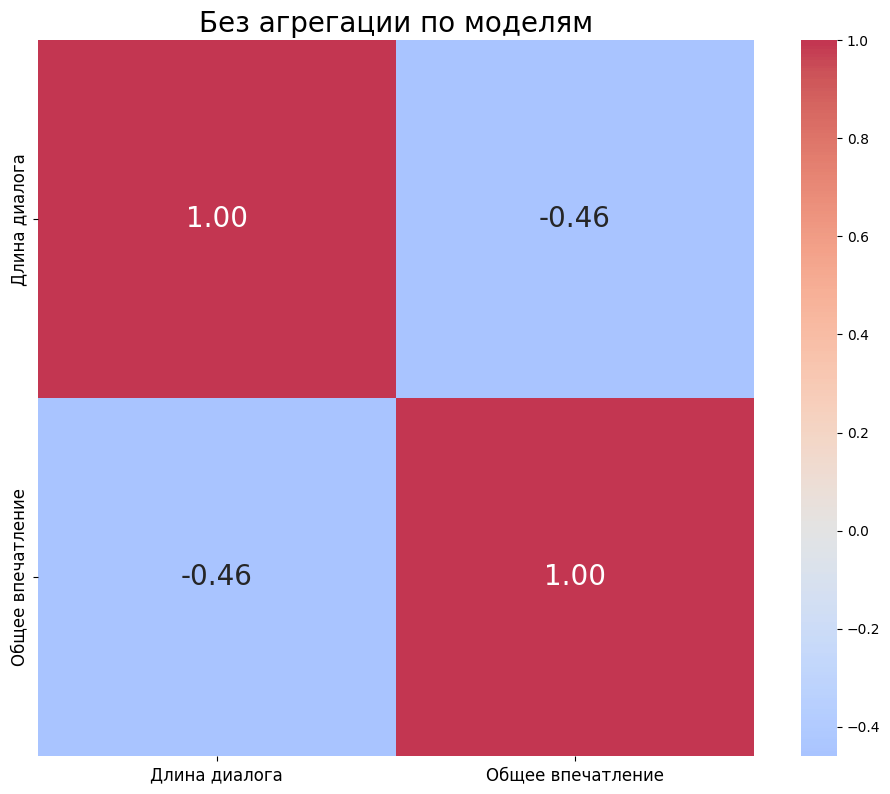

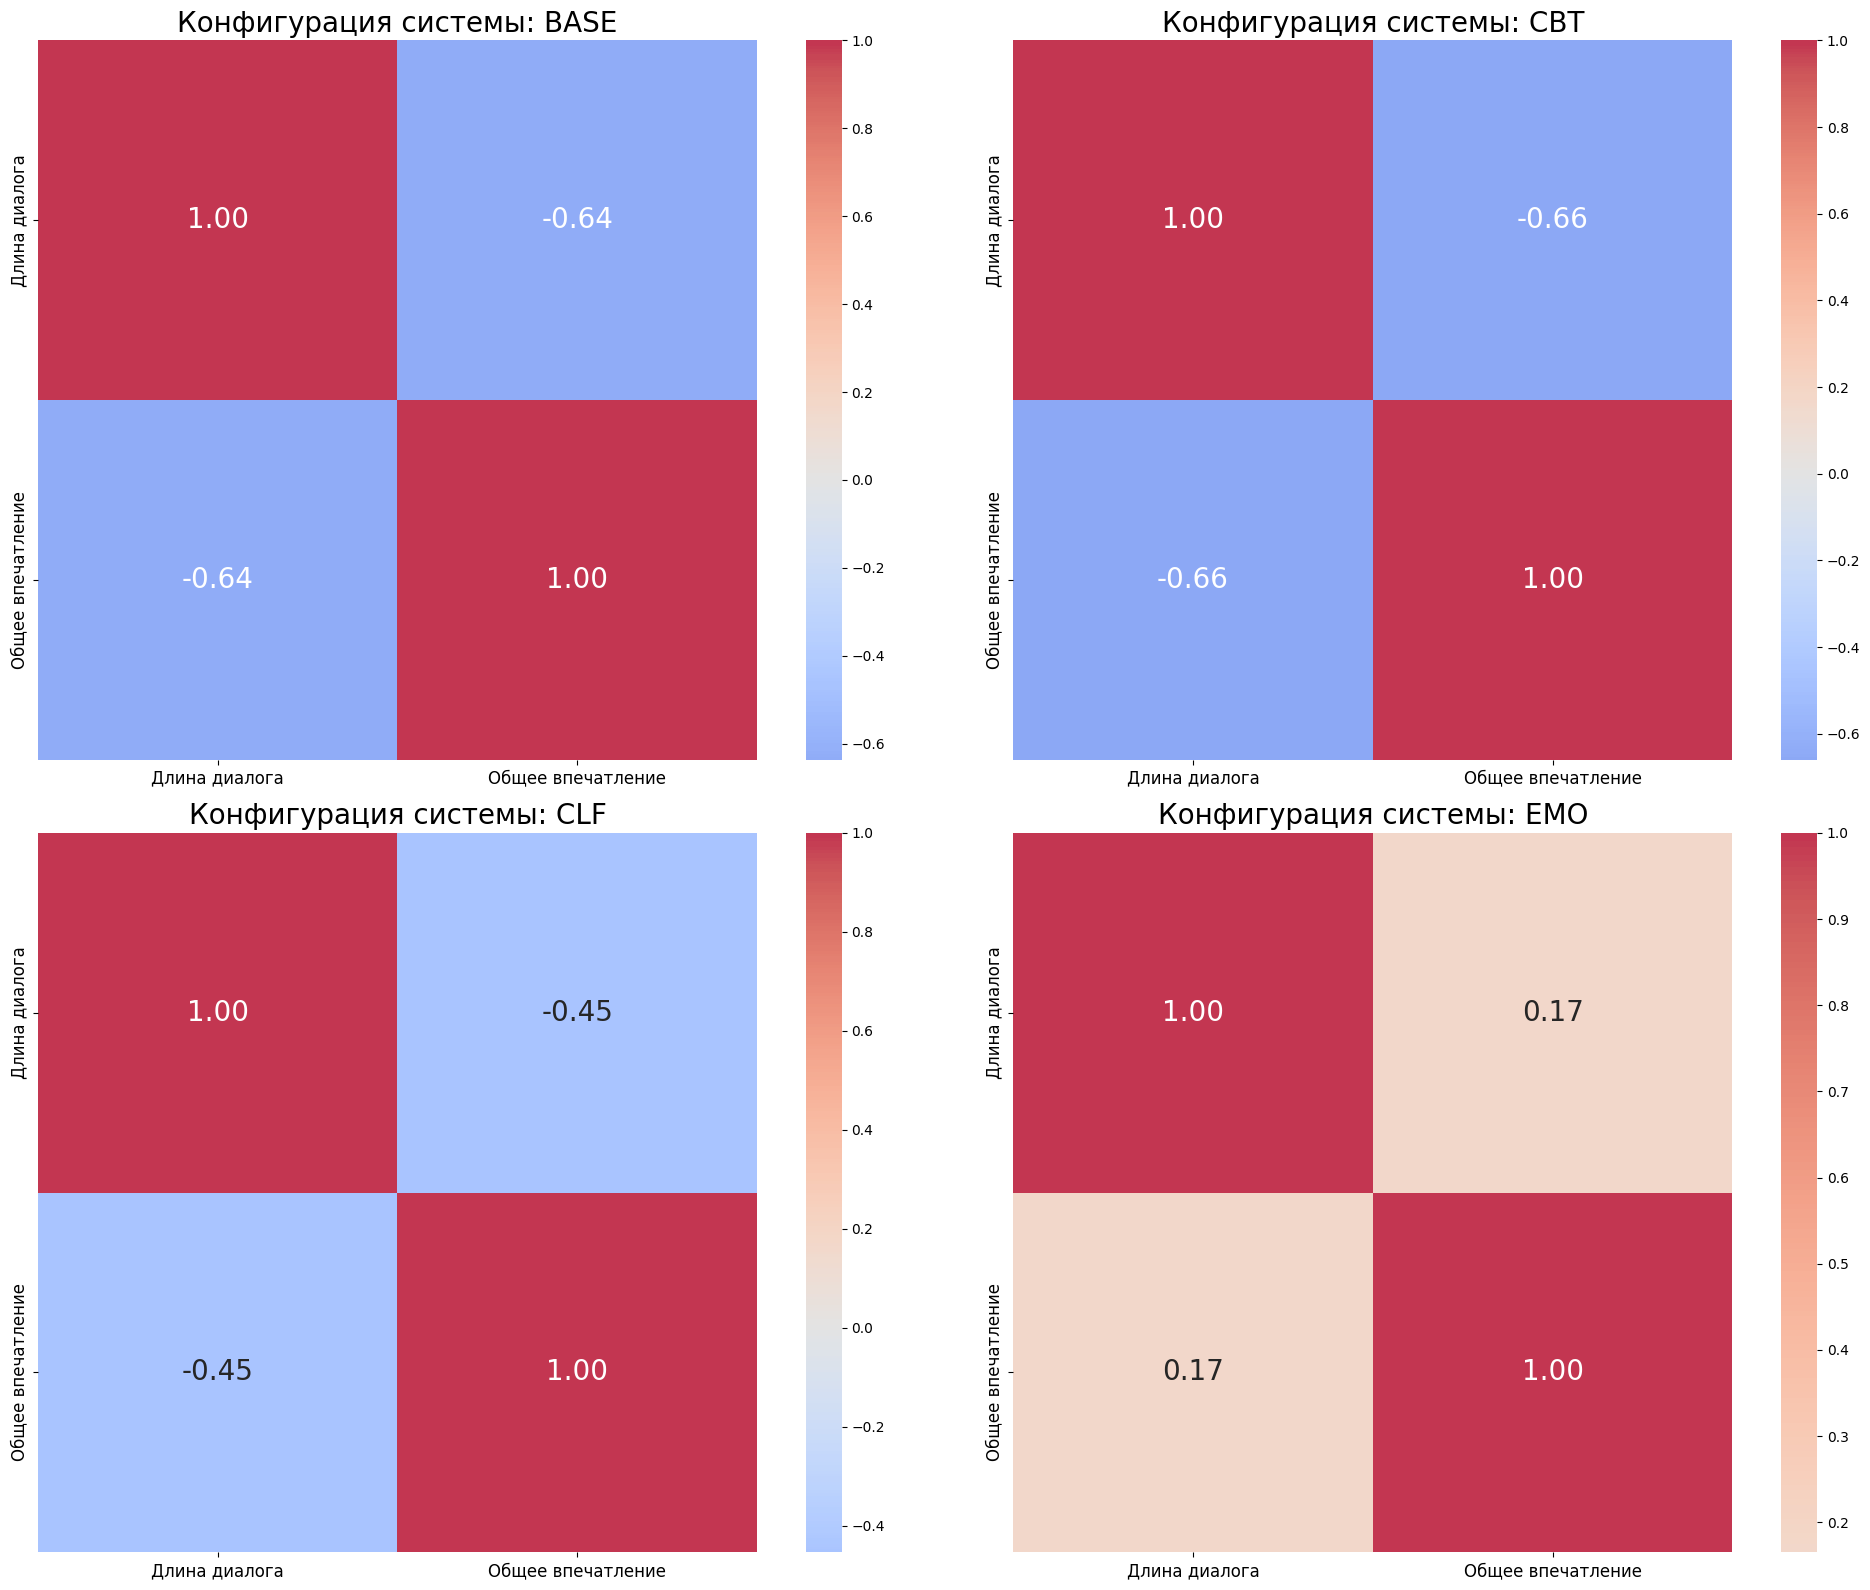

In [57]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


dialog_df_tmp = dialog_df.rename(columns={"total_user_messages": "Длина диалога", "global_rate": "Общее впечатление"})
cols = ["Длина диалога", "Общее впечатление"]

plt.figure(figsize=(10, 8))
sns.heatmap(dialog_df_tmp[cols].corr(), annot=True, fmt=".2f", cmap="coolwarm", center=0, square=True, annot_kws={"fontsize": 20}, alpha=0.8)
plt.title("Без агрегации по моделям", fontsize=20)
plt.tight_layout()
plt.tick_params(axis='both', labelsize=12)

plt.show()


import matplotlib.pyplot as plt
import seaborn as sns

def gen():
    for model, model_df in dialog_df_tmp.groupby("model"):
        yield model, model_df[cols].corr()

dfs = gen()

fig, axs = plt.subplots(2, 2, figsize=(20, 16))  # увеличенная фигура
axs = axs.flatten()

for ax in axs:
    try:
        name, corr_matrix = next(dfs)
        sns.heatmap(
            corr_matrix,
            annot=True,
            fmt=".2f",
            cmap="coolwarm",
            center=0,
            square=True,
            ax=ax,
            annot_kws={"fontsize": 20},  # размер текста в ячейках
            alpha=0.8
        )
        ax.set_title(f"Конфигурация системы: {name}", fontsize=20)  # заголовок
        ax.tick_params(axis='both', labelsize=12)  # подписи осей
    except StopIteration:
        ax.axis('off')  # скрыть пустую ось
    
plt.tight_layout()
plt.show()


In [ ]:
print("GLOBAL")
print()
print()

for model, model_df in dialog_df.groupby("model"):
    print(model)
    print(model_df[['total_user_messages', 'global_rate']].corr())
    print()

GLOBAL
                     total_user_messages  global_rate
total_user_messages             1.000000    -0.460387
global_rate                    -0.460387     1.000000

BASE
                     total_user_messages  global_rate
total_user_messages             1.000000    -0.636423
global_rate                    -0.636423     1.000000

CBT
                     total_user_messages  global_rate
total_user_messages             1.000000    -0.660225
global_rate                    -0.660225     1.000000

CLF
                     total_user_messages  global_rate
total_user_messages             1.000000    -0.453274
global_rate                    -0.453274     1.000000

EMO
                     total_user_messages  global_rate
total_user_messages             1.000000     0.165165
global_rate                     0.165165     1.000000



In [5]:
import numpy as np
dialog_df.groupby("model")["global_rate"].agg([np.mean, np.std])

/tmp/ipykernel_2015532/1822116728.py:2: FutureWarning: The provided callable <function mean at 0x7f01fc289760> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  dialog_df.groupby("model")["global_rate"].agg([np.mean, np.std])
/tmp/ipykernel_2015532/1822116728.py:2: FutureWarning: The provided callable <function std at 0x7f01fc2898a0> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  dialog_df.groupby("model")["global_rate"].agg([np.mean, np.std])


,mean,std
model,,
BASE,6.9,0.875595
CBT,7.5,1.900292
CLF,8.1,0.994429
EMO,8.6,1.505545


In [8]:
marks_df.groupby("model")[['Correctness', 'Empathetic', 'Usefullness', 'General']].agg([np.mean, np.std]).round(3).to_excel("./1.xlsx")

/tmp/ipykernel_2015532/1865452321.py:1: FutureWarning: The provided callable <function mean at 0x7f01fc289760> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  marks_df.groupby("model")[['Correctness', 'Empathetic', 'Usefullness', 'General']].agg([np.mean, np.std]).round(3).to_excel("./1.xlsx")
/tmp/ipykernel_2015532/1865452321.py:1: FutureWarning: The provided callable <function std at 0x7f01fc2898a0> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  marks_df.groupby("model")[['Correctness', 'Empathetic', 'Usefullness', 'General']].agg([np.mean, np.std]).round(3).to_excel("./1.xlsx")
/tmp/ipykernel_2015532/1865452321.py:1: FutureWarning: The provided callable <function mean at 0x7f01fc289760> is currently using SeriesGroupBy.mean. In a future

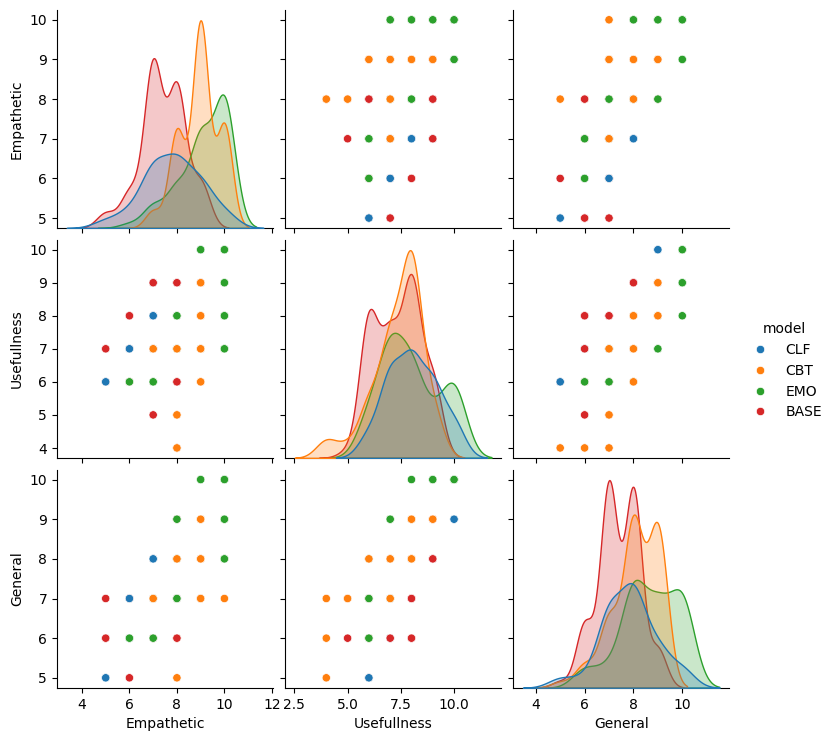


Корреляции:
             Empathetic  Usefullness   General
Empathetic     1.000000     0.460450  0.772592
Usefullness    0.460450     1.000000  0.760041
General        0.772592     0.760041  1.000000


In [158]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.pairplot(marks_df[['Empathetic', 'Usefullness', 'General', 'model']], hue='model')
plt.show()

# Корреляционная матрица
print("\nКорреляции:")
print(marks_df[['Empathetic', 'Usefullness', 'General']].corr())


# Однофакторный дисперсионный анализ

In [59]:
import itertools

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import shapiro, levene, kruskal
from statsmodels.formula.api import ols
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import scikit_posthocs as sp




def bootstrap_ci_diff(sample1, sample2, func=np.mean, n_bootstrap=1000, alpha=0.05):
    """Bootstrap доверительный интервал для разности средних или медиан"""
    diffs = []
    for _ in range(n_bootstrap):
        s1 = np.random.choice(sample1, size=len(sample1), replace=True)
        s2 = np.random.choice(sample2, size=len(sample2), replace=True)
        diffs.append(func(s1) - func(s2))
    lower = np.percentile(diffs, 100 * (alpha / 2))
    upper = np.percentile(diffs, 100 * (1 - alpha / 2))
    return lower, upper


def prettify_dunn_test(dunn_matrix, df, criterion_col, group_col, alpha=0.05, method='mean'):
    """Приводит Dunn матрицу в читаемый формат с meandiff/mediandiff и bootstrap CI"""
    results = []
    func = np.mean if method == 'mean' else np.median

    group_names = dunn_matrix.columns.tolist()

    for g1, g2 in itertools.combinations(group_names, 2):
        p_val = dunn_matrix.loc[g1, g2]
        s1 = df[df[group_col] == g1][criterion_col].values
        s2 = df[df[group_col] == g2][criterion_col].values
        diff = func(s1) - func(s2)
        lower, upper = bootstrap_ci_diff(s1, s2, func=func, alpha=alpha)

        results.append({
            'group1': g1,
            'group2': g2,
            f'{method}diff': diff,
            'p-adj': p_val,
            'ci_lower': lower,
            'ci_upper': upper,
            'reject': p_val < alpha
        })

    return pd.DataFrame(results)


def analyze_by_criterion(df, criterion_col, group_col='model', alpha=0.05):
    print(f"\n=== Анализ критерия: {criterion_col} ===")

    # Уникальные группы
    groups = df[group_col].unique()
    samples = [df[df[group_col] == g][criterion_col] for g in groups]

    # --- Шаг 1: Проверка нормальности
    normal = True
    print("\nShapiro-Wilk (проверка нормальности):")
    for g, s in zip(groups, samples):
        stat, p = shapiro(s)
        print(f"{g}: p = {p:.4f}")
        if p < alpha:
            normal = False

    # --- Шаг 2: Проверка равенства дисперсий
    stat, p = levene(*samples)
    print(f"\nLevene test (гомогенность дисперсий): p = {p:.4f}")
    equal_var = p >= alpha

    # --- Шаг 3: Выбор метода
    if normal and equal_var:
        print("\n✅ Данные нормальны, дисперсии равны — используем ANOVA + Tukey HSD")
        model = ols(f'{criterion_col} ~ C({group_col})', data=df).fit()
        anova_table = sm.stats.anova_lm(model, typ=2)
        print("\nANOVA:")
        print(anova_table)

        tukey = pairwise_tukeyhsd(df[criterion_col], df[group_col], alpha=alpha)
        print("\nTukey HSD:")
        print(tukey.summary())
    else:
        print("\n⚠️ Нарушены предпосылки — используем Kruskal–Wallis + Dunn’s test")
        stat, p = kruskal(*samples)
        print(f"\nKruskal–Wallis: p = {p:.4f}")
        if p < alpha:
            print("\nDunn’s post-hoc test:")
            dunn = sp.posthoc_dunn(df, val_col=criterion_col, group_col=group_col, p_adjust='bonferroni')
            print(prettify_dunn_test(dunn, df=marks_df, criterion_col=criterion_col, group_col='model', method='mean'))
        else:
            print("Нет статистически значимых различий между группами.")


In [60]:
analyze_by_criterion(marks_df, criterion_col='General')


=== Анализ критерия: General ===

Shapiro-Wilk (проверка нормальности):
CLF: p = 0.0010
CBT: p = 0.0000
EMO: p = 0.0000
BASE: p = 0.0000

Levene test (гомогенность дисперсий): p = 0.1153

⚠️ Нарушены предпосылки — используем Kruskal–Wallis + Dunn’s test

Kruskal–Wallis: p = 0.0000

Dunn’s post-hoc test:
  group1 group2  meandiff         p-adj  ci_lower  ci_upper  reject
0   BASE    CBT -0.680068  8.842679e-05 -0.958818 -0.403682    True
1   BASE    CLF -0.420192  1.391620e-01 -0.743317 -0.058510   False
2   BASE    EMO -1.268750  3.052732e-11 -1.615703 -0.940547    True
3    CBT    CLF  0.259875  6.225858e-01 -0.086344  0.614384   False
4    CBT    EMO -0.588682  4.308643e-02 -0.940509 -0.277924    True
5    CLF    EMO -0.848558  3.278819e-04 -1.242849 -0.448287    True


In [61]:
analyze_by_criterion(marks_df, criterion_col='Empathetic')


=== Анализ критерия: Empathetic ===

Shapiro-Wilk (проверка нормальности):
CLF: p = 0.0061
CBT: p = 0.0000
EMO: p = 0.0000
BASE: p = 0.0000

Levene test (гомогенность дисперсий): p = 0.0215

⚠️ Нарушены предпосылки — используем Kruskal–Wallis + Dunn’s test

Kruskal–Wallis: p = 0.0000

Dunn’s post-hoc test:
  group1 group2  meandiff         p-adj  ci_lower  ci_upper  reject
0   BASE    CBT -1.519932  2.057105e-14 -1.780068 -1.272272    True
1   BASE    CLF -0.395192  3.013897e-01 -0.789543  0.008678   False
2   BASE    EMO -1.696875  9.506241e-17 -2.025000 -1.359141    True
3    CBT    CLF  1.124740  2.137291e-06  0.760915  1.458498    True
4    CBT    EMO -0.176943  1.000000e+00 -0.478885  0.134322   False
5    CLF    EMO -1.301683  4.328209e-08 -1.727163 -0.909796    True


In [62]:
analyze_by_criterion(marks_df, criterion_col='Usefullness')


=== Анализ критерия: Usefullness ===

Shapiro-Wilk (проверка нормальности):
CLF: p = 0.0013
CBT: p = 0.0000
EMO: p = 0.0000
BASE: p = 0.0000

Levene test (гомогенность дисперсий): p = 0.3162

⚠️ Нарушены предпосылки — используем Kruskal–Wallis + Dunn’s test

Kruskal–Wallis: p = 0.0033

Dunn’s post-hoc test:
  group1 group2  meandiff     p-adj  ci_lower  ci_upper  reject
0   BASE    CBT -0.027365  1.000000 -0.389738  0.313176   False
1   BASE    CLF -0.700962  0.010909 -1.069375 -0.330697    True
2   BASE    EMO -0.631250  0.060673 -1.056328 -0.246875   False
3    CBT    CLF -0.673597  0.062160 -1.101949 -0.284200   False
4    CBT    EMO -0.603885  0.279406 -1.008889 -0.193412   False
5    CLF    EMO  0.069712  1.000000 -0.395553  0.502494   False


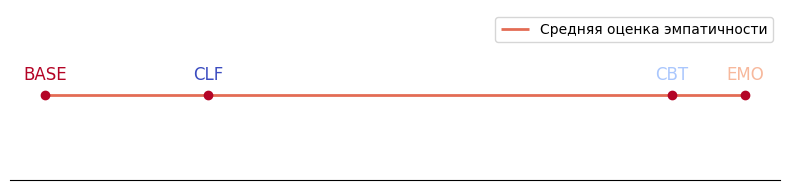

In [80]:
import matplotlib.pyplot as plt

# Точки и их подписи
points = [0., 0.395, 1.52, 1.697]
labels = ['BASE', 'CLF', 'CBT', 'EMO']

# Рисуем ось и отрезок
fig, ax = plt.subplots(figsize=(8, 2))
ax.hlines(0, min(points), max(points), colors=plt.cm.coolwarm([0.85]), linewidth=2, label="Средняя оценка эмпатичности")  # отрезок

# Добавляем точки и подписи
for x, label in zip(points, labels):
    ax.plot(x, 0, 'o', color=color_mapping["BASE"])  # точка
    ax.text(x, 0.01, label, ha='center', fontsize=12, color=color_mapping[label])  # подпись чуть выше

# Убираем оси для чистоты
ax.set_yticks([])
ax.set_xticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.tight_layout()
plt.legend()
plt.show()


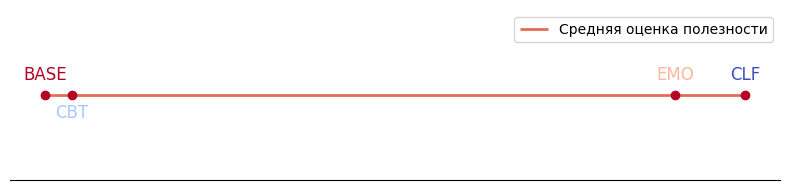

In [89]:
import matplotlib.pyplot as plt

# Точки и их подписи
points = [0., 0.027, 0.631, 0.701]
labels = ['BASE', 'CBT', 'EMO', 'CLF']

# Рисуем ось и отрезок
fig, ax = plt.subplots(figsize=(8, 2))
ax.hlines(0, min(points), max(points), colors=plt.cm.coolwarm([0.85]), linewidth=2, label="Средняя оценка полезности")  # отрезок

# Добавляем точки и подписи
for x, label in zip(points, labels):
    ax.plot(x, 0, 'o', color=color_mapping["BASE"])  # точка
    ax.text(x, (0.01 if label != "CBT" else -0.015), label, ha='center', fontsize=12, color=color_mapping[label])  # подпись чуть выше

# Убираем оси для чистоты
ax.set_yticks([])
ax.set_xticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.tight_layout()
plt.legend()
plt.show()


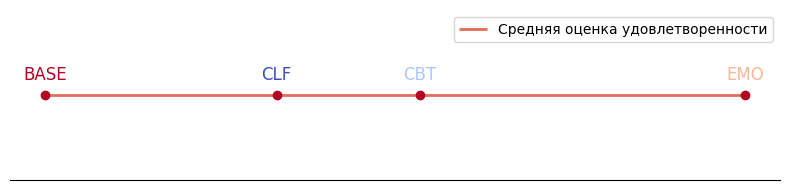

In [90]:
import matplotlib.pyplot as plt

# Точки и их подписи
points = [0., 0.42, 0.68, 1.269]
labels = ['BASE', 'CLF', 'CBT', 'EMO']

# Рисуем ось и отрезок
fig, ax = plt.subplots(figsize=(8, 2))
ax.hlines(0, min(points), max(points), colors=plt.cm.coolwarm([0.85]), linewidth=2, label="Средняя оценка удовлетворенности")  # отрезок

# Добавляем точки и подписи
for x, label in zip(points, labels):
    ax.plot(x, 0, 'o', color=color_mapping["BASE"])  # точка
    ax.text(x, 0.01, label, ha='center', fontsize=12, color=color_mapping[label])  # подпись чуть выше

# Убираем оси для чистоты
ax.set_yticks([])
ax.set_xticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.tight_layout()
plt.legend()
plt.show()


# Визуализация процесса обучения

In [ ]:
pth = "../../models/llm/{}/{}/"

def gen():
    for k in [
        "Amod-mental_health_counseling_conversations", "entfane-psychotherapy", "mrs83-kurtis_mental_health_final",
        "tcabanski-mental_health_counseling_responses", "ShenLab-MentalChat16K", "Psychotherapy-LLM-PsychoCounsel-Preference"
    ]:
        yield k

g = gen()     

data = []
for ds_name in g:
    checkpoints = {}
    for mode in ["emo", "no_emo"]:
        files = []
        for dr in os.listdir(pth.format(mode, ds_name)):
            if "checkpoint" in dr:
                files.append((int(dr.split("-")[1]), dr))
        files = sorted(files, key=lambda x: x[0])
        checkpoints[mode] = files
    checkpoint_i = 0

    tmp = {}
    for mode, c in zip(["emo", "no_emo"], plt.cm.coolwarm(np.linspace(0, 1, 2))):
        file = pth.format(mode, ds_name) + checkpoints[mode][checkpoint_i][1] + "/trainer_state.json"
        with open(file, "r", encoding="utf-8") as f:
            df = pd.DataFrame(json.load(f)["log_history"])

        tmp[f"mean_train_loss_{mode}"] = df["loss"].mean()
        tmp[f"mean_token_accuracy_{mode}"] = df["mean_token_accuracy"].mean()
    tmp["dataset"] = ds_name
    data.append(tmp)

df = pd.DataFrame(data)

print(df.head())

(sum((df["mean_train_loss_emo"] - df["mean_train_loss_no_emo"]) ** 2) / len(df)) ** 0.5, (sum((df["mean_token_accuracy_emo"] - df["mean_token_accuracy_no_emo"]) ** 2) / len(df)) ** 0.5

,mean_train_loss_emo,mean_token_accuracy_emo,mean_train_loss_no_emo,mean_token_accuracy_no_emo,dataset
0,1.784800,0.572140,1.681917,0.592829,Amod-mental_health_counseling_conversations
1,1.022600,0.702350,1.091350,0.688467,entfane-psychotherapy
2,0.838800,0.747214,0.905570,0.731348,mrs83-kurtis_mental_health_final
3,0.509968,0.857961,0.484424,0.862294,tcabanski-mental_health_counseling_responses
4,0.745105,0.766821,0.813046,0.750764,ShenLab-MentalChat16K
5,0.816163,0.751728,0.877960,0.738460,Psychotherapy-LLM-PsychoCounsel-Preference


<Figure size 1000x600 with 0 Axes>

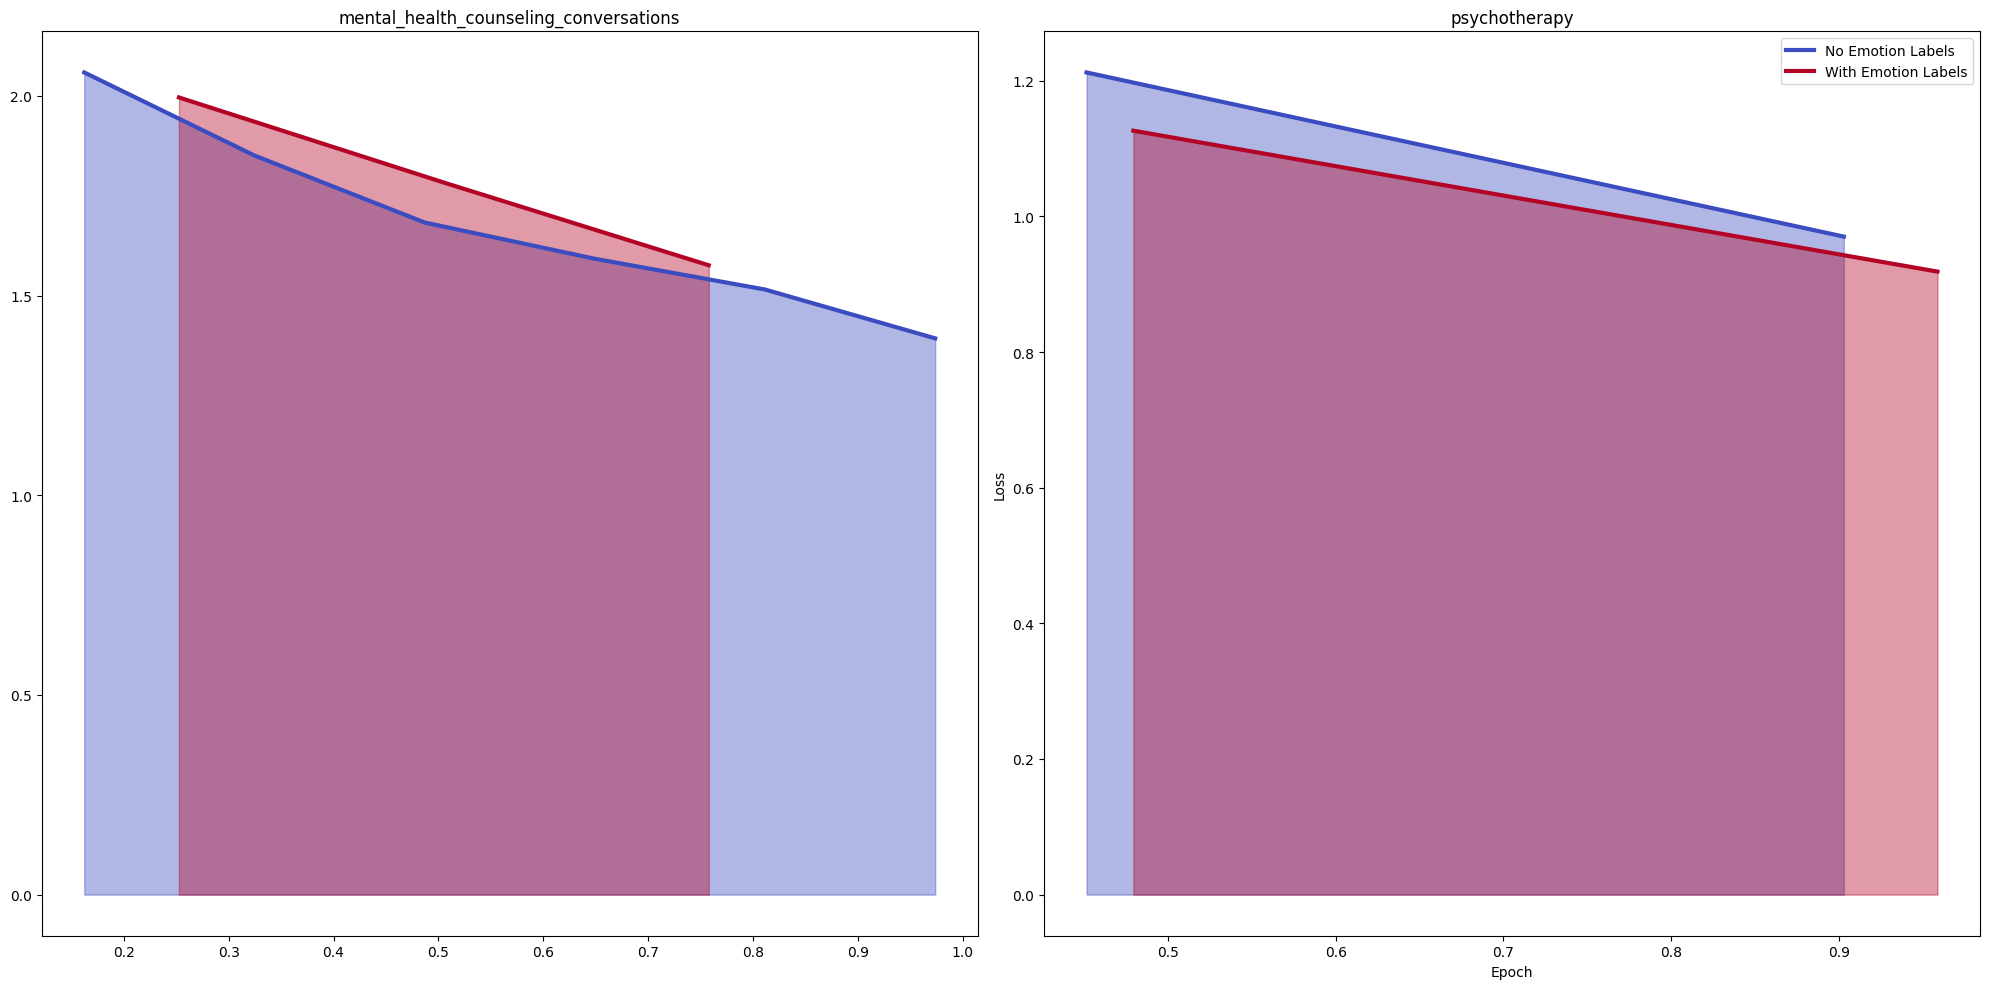

<Figure size 1000x600 with 0 Axes>

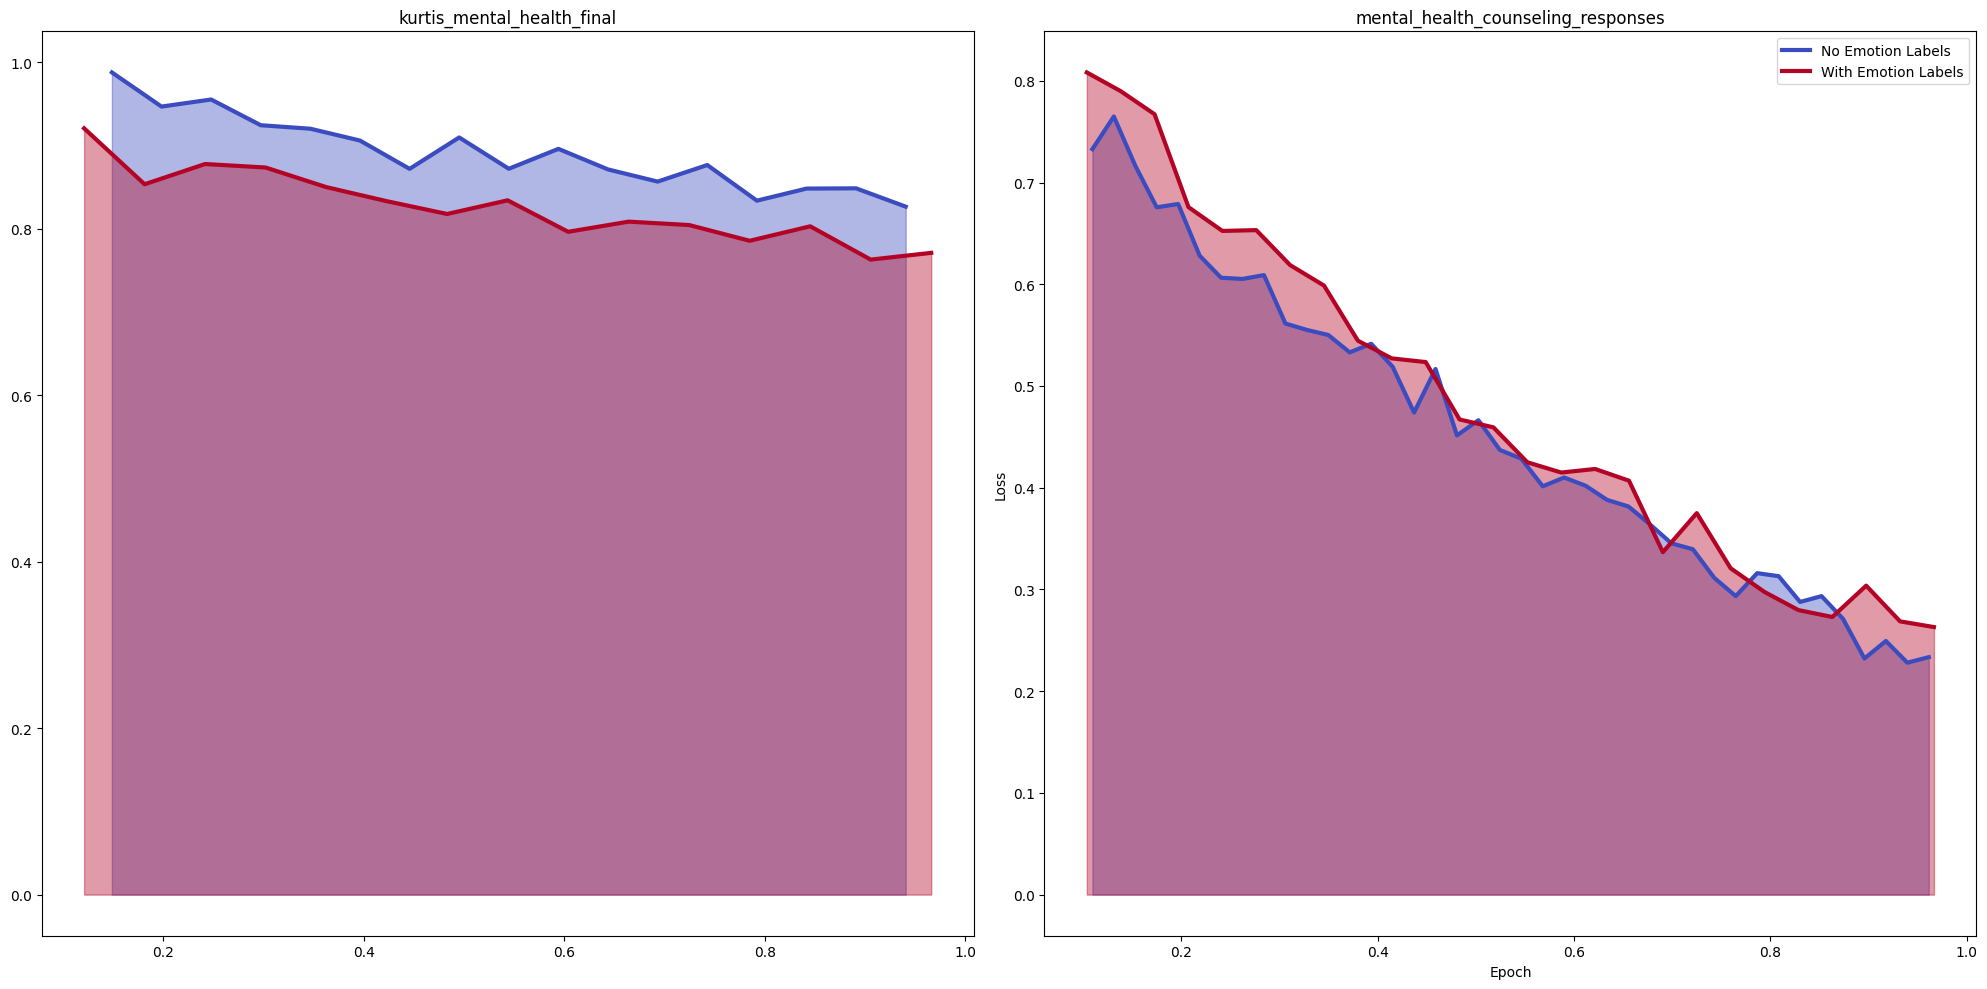

<Figure size 1000x600 with 0 Axes>

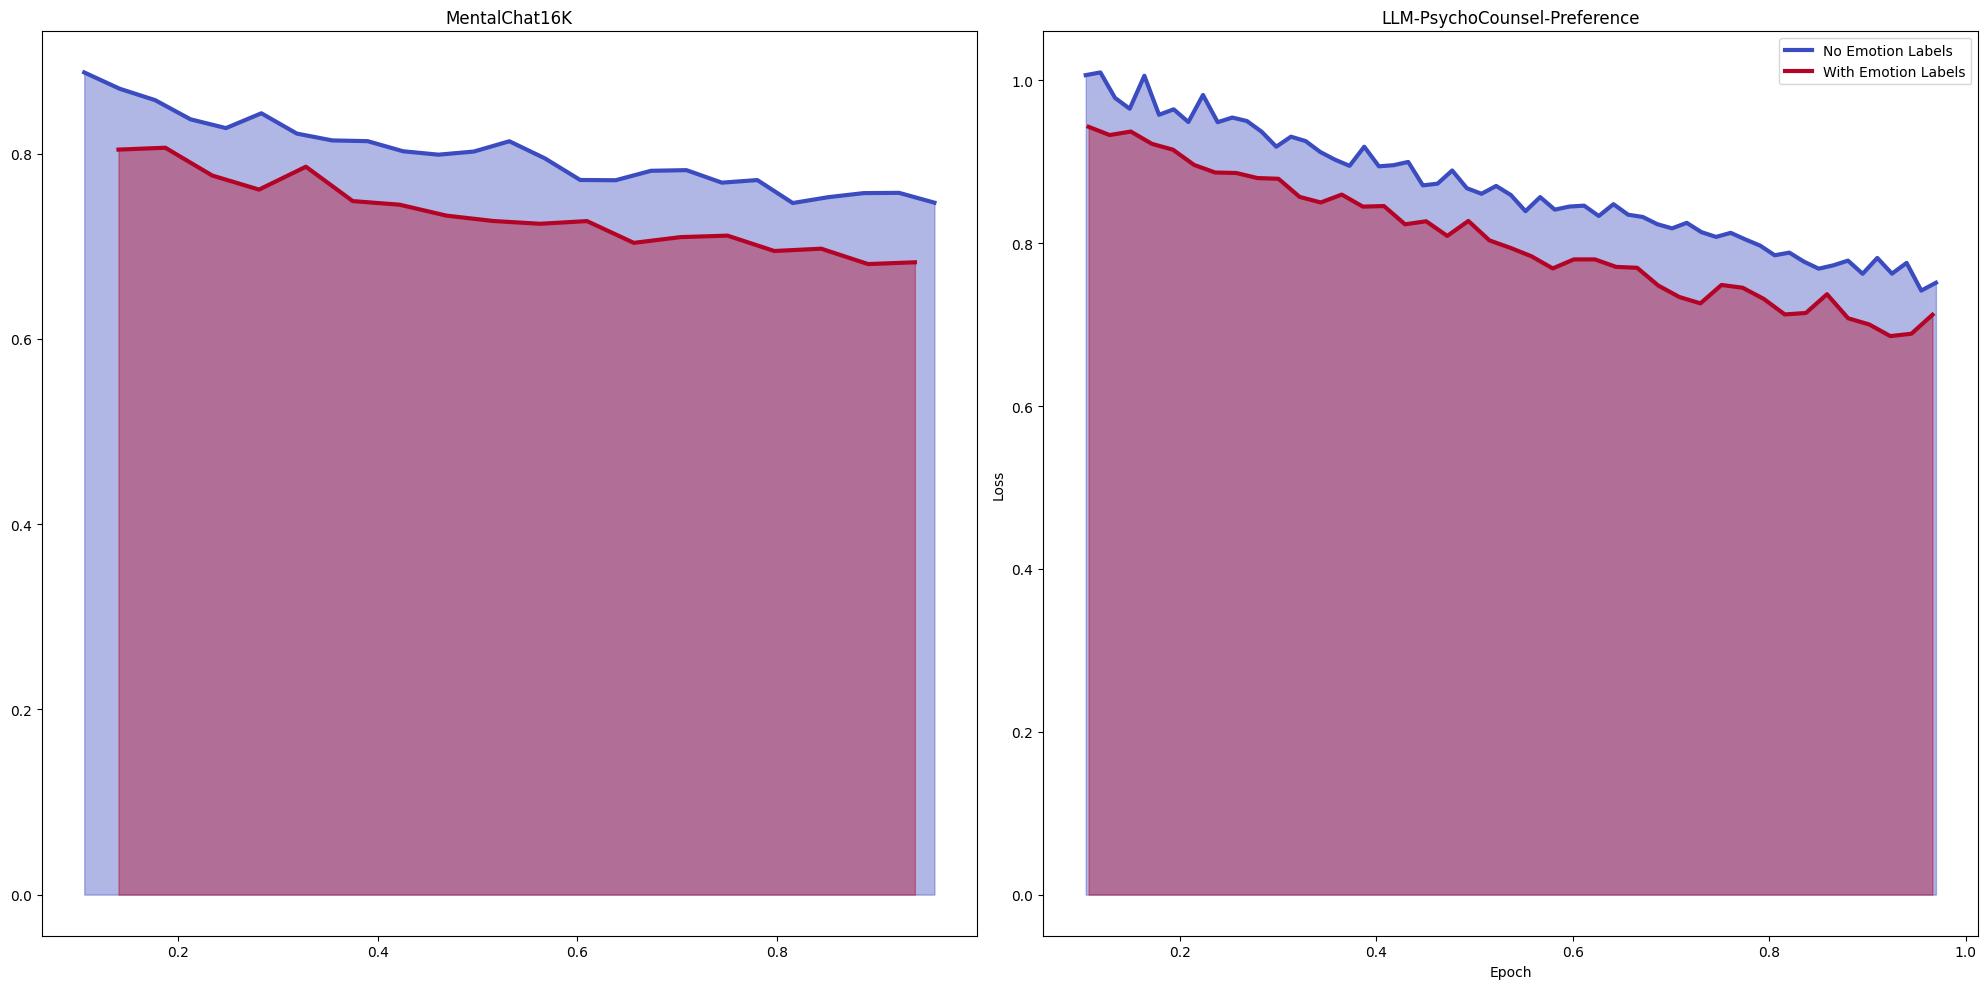

In [18]:
import matplotlib.pyplot as plt
import os
import pandas as pd
import json
import numpy as np

pth = "../../models/llm/{}/{}/"


def gen():
    for k in [
        "Amod-mental_health_counseling_conversations", "entfane-psychotherapy", "mrs83-kurtis_mental_health_final",
        "tcabanski-mental_health_counseling_responses", "ShenLab-MentalChat16K", "Psychotherapy-LLM-PsychoCounsel-Preference"
    ]:
        yield k


g = gen()


for _ in range(3):
    plt.figure(figsize=(10, 6))
    fig, axs = plt.subplots(1, 2, figsize=(20, 10))  # Один ряд, два столбца
    for ax in axs:
        ds_name = next(g)
        checkpoints = {}
        for mode in ["emo", "no_emo"]:
            files = []
            for dr in os.listdir(pth.format(mode, ds_name)):
                if "checkpoint" in dr:
                    files.append((int(dr.split("-")[1]), dr))
            files = sorted(files, key=lambda x: x[0])
            checkpoints[mode] = files
        checkpoint_i = 0

        for mode, c in zip(["no_emo", "emo"], plt.cm.coolwarm(np.linspace(0, 1, 2))):
            file = pth.format(mode, ds_name) + checkpoints[mode][checkpoint_i][1] + "/trainer_state.json"
            with open(file, "r", encoding="utf-8") as f:
                df = pd.DataFrame(json.load(f)["log_history"])
            df.fillna(0, inplace=True)
            df["loss"] += df["eval_loss"]

            df = df.query("0.1 <= epoch <= 0.98")

            label = "With Emotion Labels" if mode == "emo" else "No Emotion Labels"
            ax.plot(df['epoch'], df['loss'], label=label, color=c, linewidth=3)
            ax.fill_between(df['epoch'], df['loss'], alpha=0.4, color=c)
            ax.set_title("-".join(ds_name.split("-")[1:]))
        
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()
